In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import read_pickle

from inference import gph2xy, diam, nx_dist, l_tot, nb_apex

path = "./Data/M2"

filenames_ = os.listdir(path)
filenames = []

for file in filenames_ :
    if file[-7:] == 'gpickle':
        filenames += [file]

data = [] #list of lengths of open segments
length = 0 #total length
nb = 0 #number of apexes

for file in filenames:
    g = read_pickle(path + '/' + file)
    d = diam(g)
    data += nx_dist(g, min_diameter=d*0.6, euclidean=False)
    length += l_tot(g, min_diameter=d*0.6)
    nb += nb_apex(g, min_diameter=d*0.6)

lbdhat = nb/length

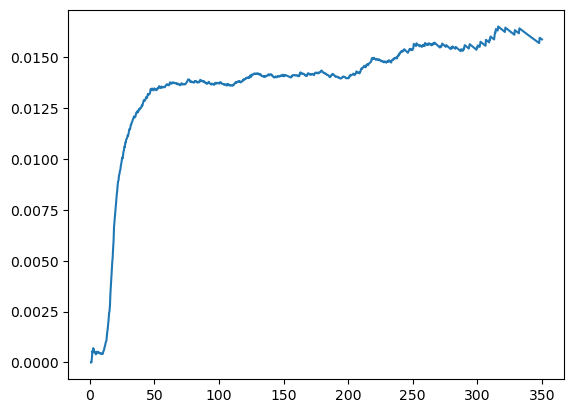

In [2]:
def F(data, x): 
    """
    Compute the empirical tail distribution in lengths of open segments
    
    Args:
        data (list): list[float] of lengths of open segments
        x (float)
    """
    return len([y for y in data if y > x])/len(data)

X = np.linspace(1, 350, 1000)
Y = [F(data, x) for x in X]
plt.plot(X, -np.log(Y)/X)


In [3]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

def bhat(data, interval):
    """
    Estimate b1 and b2
    
    Args:
        data: list[int] of V1-V3 distances
        interval: list[float] of length 2
    """
    X = np.linspace(interval[0], interval[1], 2000)
    Y = np.array([-np.log(F(data, x))/x for x in X])
    Z = np.ones(np.shape(X))
    
    def f(b):
        lbd_ = (b[0] + np.sqrt(b[0]**2 + 4*b[1]))/2
        return sum((Y - (b[0]+lbd_)*Z - b[1]/2*X)**2)
    
    bounds = Bounds([0, 0], [np.inf, np.inf])
    
    b_min = minimize(f, [0, 0], bounds=bounds)

    return b_min['x']

b1, b2 = bhat(data, [50, 300])
print(b1, b2)
print(0.5*(b1 + np.sqrt(b1**2 + 4*b2)))
print(lbdhat)

0.0052604623567175405 1.775846342518855e-05
0.007597783843082026
0.007782738747855674


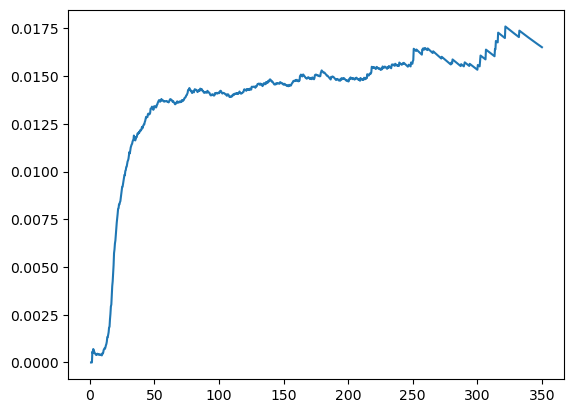

In [4]:
from random import choices

data_ = choices(data, k=len(data))
Y_ = [F(data_, x) for x in X]
plt.plot(X, -np.log(Y_)/X)

In [5]:
bhat(data_, [50, 300])

array([5.34425324e-03, 1.94212642e-05])

In [6]:
def bootstrap_bhat(data, interval, B):
    """
    Estimate b1 and b2 and compute standard deviation using bootstrap
    
    Args:
        data: list[int] of V1-V3 distances
        interval: list[float] of length 2
        B (int): number of iterations
    """
    N = len(data)
    
    B1 = []
    B2 = []
    
    for i in range(B):
        data_ = choices(data, k=N)
        b1, b2 = bhat(data_, interval)
        B1.append(b1)
        B2.append(b2)
        
    B1 = np.array(B1)
    B2 = np.array(B2)
        
    LBD = (B1 + np.sqrt(B1**2 + 4*B2))/2

    b1_moy = np.mean(B1)   
    b2_moy = np.mean(B2)
    lbd_moy = np.mean(LBD)
      
    std1 = np.std(B1)
    std2 = np.std(B2)
    stdlbd = np.std(LBD)
    
    return([[b1_moy, std1], [b2_moy, std2], [lbd_moy, stdlbd]])

bootstrap_bhat(data, [50, 300], 100)

[[0.005199207901194548, 0.0005805161594496925],
 [1.8419068714564953e-05, 6.1920761270650935e-06],
 [0.00760345855680453, 0.00022928155863298014]]